In [187]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import ingest
import numpy as np
import pandas as pd
df = ingest.setup('../../valid/capture/capture1')

Dropped 1 outlier coordinate


In [192]:
import warnings
from localization_error import error, error_methods, smoothing_methods
warnings.filterwarnings('ignore')
errors = error(df, error_methods)
#errors_uncorrected = ingest.error(ingest.error_methods, true_bearing=False)
#errors_dbm = ingest.error(ingest.error_methods, mw=False)

HBox(children=(IntProgress(value=0, description='Preparing data', max=4342), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Interpolating', max=52104), HTML(value='')))

In [186]:
# Print the median results by method
for smooth in pd.unique(errors.smooth):
    errors_display = errors[errors.smooth==smooth].groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
    #errors_display.plot(kind='bar', title="Overall")
    print(errors_display)
errors_display = errors[errors.smooth.isnull()].groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#errors_display.plot(kind='bar', title="Overall")
print(errors_display)

# Errors in dbm
#errors_display_dbm = errors_display = errors_dbm.groupby('method')['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#print(errors_display_dbm)

Series([], Name: error, dtype: float64)
method
from_derivatives        15.741001
piecewise_polynomial    15.741001
slinear                 15.741001
linear                  15.765779
pchip                   15.948783
akima                   16.579832
naive                   21.875756
barycentric             23.355267
cubic                   24.972145
quadratic               26.188043
krogh                   62.987834
random                  89.657768
Name: error, dtype: float64
method
from_derivatives        18.905325
linear                  18.905325
piecewise_polynomial    18.905325
slinear                 18.905325
pchip                   19.050353
akima                   19.396193
naive                   25.558790
quadratic               29.444840
cubic                   30.972145
barycentric             31.399127
krogh                   53.899538
random                  90.875756
Name: error, dtype: float64
method
pchip                   12.978213
from_derivatives        13.600873

In [194]:
errors_display = errors.groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#errors_display.plot(kind='bar', title="Overall")
print(errors_display)

method
pchip                   13.697475
from_derivatives        14.312019
piecewise_polynomial    14.312019
naive                   14.697475
slinear                 14.827605
linear                  15.092330
akima                   16.441210
barycentric             22.827605
cubic                   24.942384
quadratic               25.697475
krogh                   59.284347
random                  90.438635
Name: error, dtype: float64


method
naive                    55.784419
linear                   56.266300
akima                    56.927015
slinear                  56.996334
pchip                    57.043841
from_derivatives         57.637782
piecewise_polynomial     57.637782
cubic                    64.547352
quadratic                65.409313
barycentric              66.048154
krogh                    91.519456
random                  103.298418
dtype: float64


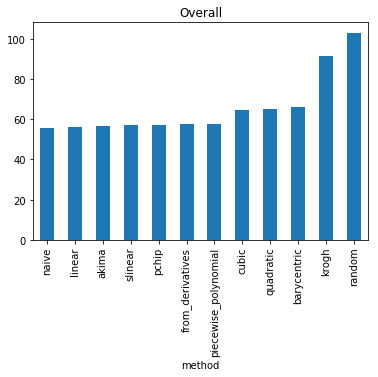

In [33]:
from math import sqrt

def err(truth, prediction):
    _err = (truth - prediction) % 360
    _too_big = np.abs(_err) > 180
    _err[_too_big] = -((360 - (_err[_too_big])) % 360)
    return _err

errors_display_rms = errors.groupby('method').apply(lambda row: sqrt((pd.Series(err(row['bearing'], row['guess'])) ** 2).mean())).sort_values()
errors_display_rms.plot(kind='bar', title="Overall")
print(errors_display_rms)

Text(0,0.5,'error (degrees)')

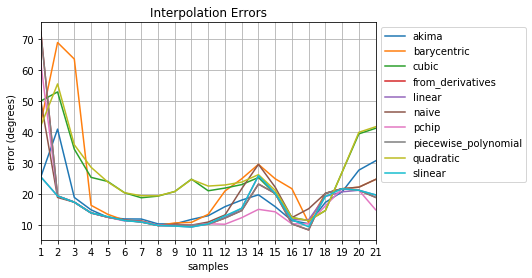

In [21]:
# For display purposes, eliminate Random and Krogh
median_errors = errors.groupby(['method', 'samples'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).unstack().T
median_errors_reduced = median_errors.drop(median_errors[['random','krogh']], axis=1)
#median_errors_reduced = median_errors
ax = median_errors_reduced.plot(xticks=median_errors_reduced.index.values, grid=True, title="Interpolation Errors")
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("error (degrees)")

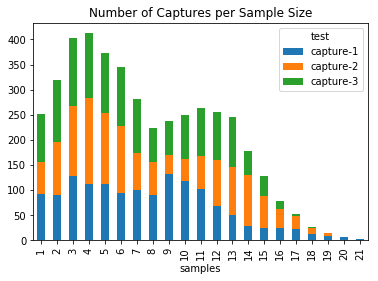

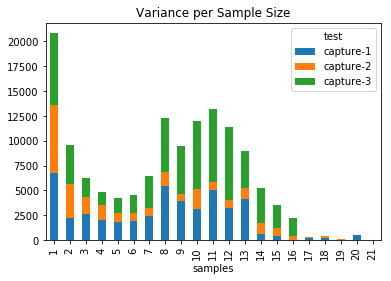

In [12]:
sample_spread = errors[errors['method']=='naive'].groupby(['test','samples'])['error'].count().unstack().T
sample_spread.plot(kind='bar', stacked=True, title="Number of Captures per Sample Size")

variance_spread = errors[errors['method']=='naive'].groupby(['test','samples'])['error'].var().unstack().T
variance_spread.plot(kind='bar', stacked=True, title="Variance per Sample Size")


smoothing...


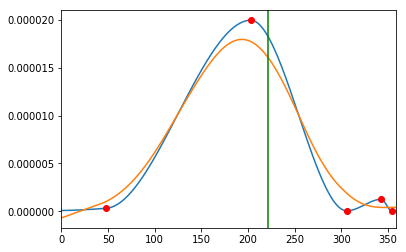

In [133]:
import locate
from localization_error import prep_for_plot
def get_nsample_set(n):
    rando = errors[(errors['samples']==n) & (errors['method']=='naive')].reset_index()
    i = np.random.randint(len(rando))
    test = rando.iloc[i]['test']
    pass_n = rando.iloc[i]['pass']
    bssid = rando.iloc[i]['bssid']
    return ingest.get_set(test, pass_n, bssid), test, bssid

the_set, test, bssid = get_nsample_set(5)
series = prep_for_plot(the_set)

interp = locate.interpolate(series, 'pchip', plot=True, test=test, bssid=bssid)


In [32]:
# Show the best methods for each number of samples
ntop = 5
idx = pd.MultiIndex.from_product([['method','error'],range(0,5)])
top_methods = median_errors.T.apply(lambda x: pd.Series(pd.concat([pd.Series(x.nsmallest(ntop).index, dtype=np.dtype(object)), pd.Series(x.nsmallest(ntop).values, dtype=np.dtype(object))])))
top_methods.set_index(idx, inplace=True)
top_methods = top_methods.swaplevel(1,0).sort_index()
top_methods

samples          1                 2                     3   \
0 error     25.6038           18.9704               17.4412   
  method      akima             naive      from_derivatives   
1 error     25.6038           19.4412               17.4412   
  method      krogh             pchip                linear   
2 error     25.6038           19.4412               17.4412   
  method     linear           slinear                 naive   
3 error     25.6038           19.4539               17.4412   
  method    slinear  from_derivatives                 pchip   
4 error     42.0947           19.4539               17.4412   
  method  quadratic            linear  piecewise_polynomial   

samples                     4                 5                 6   \
0 error                13.9782           12.5774           11.3657   
  method      from_derivatives             akima             pchip   
1 error                13.9782           12.6009           11.4928   
  method                linear  from_derivatives           slinear   
2 error                13.9782           12.6009           11.6009   
  method                 naive            linear       barycentric   
3 error                13.9782           12.6009           11.6009   
  method                 pchip             naive  from_derivatives   
4 error                13.9782           12.6009           11.6009   
  method  piecewise_polynomial             pchip            linear   

samples                     7                     8                     9   \
0 error                11.0367               9.92715                 9.741   
  method      from_derivatives           barycentric                linear   
1 error                11.0367               9.92715                 9.741   
  method  piecewise_polynomial      from_derivatives               slinear   
2 error                11.0367               9.92715               9.92715   
  method               slinear                linear      from_derivatives   
3 error                11.2012               9.92715               9.92715   
  method                linear                 naive                 pchip   
4 error                11.2012               9.92715               9.92715   
  method                 pchip  piecewise_polynomial  piecewise_polynomial   

samples                 10          ...                             12  \
0 error            9.43864          ...                        10.3233   
  method            linear          ...                          pchip   
1 error            9.43864          ...                        12.3233   
  method           slinear          ...               from_derivatives   
2 error            10.0367          ...                        12.3233   
  method  from_derivatives          ...           piecewise_polynomial   
3 error            10.0367          ...                        12.4731   
  method             naive          ...                         linear   
4 error            10.0367          ...                        13.0367   
  method             pchip          ...                        slinear   

samples                     13                    14                15  \
0 error                12.4386               15.1318           14.3413   
  method                 pchip                 pchip             pchip   
1 error                 14.741               19.8211           15.9975   
  method      from_derivatives                 akima             akima   
2 error                 14.741               23.2906           20.0573   
  method  piecewise_polynomial      from_derivatives             cubic   
3 error                15.4731               23.2906           20.2906   
  method                linear  piecewise_polynomial  from_derivatives   
4 error                15.4731               25.3982           20.2906   
  method               slinear                 cubic            linear   

samples                     16                